<a href="https://colab.research.google.com/github/BimsaraS99/stable-diffusion-xl1.0-inference/blob/main/stable_diffuser_XL1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq diffusers["torch"] transformers

In [2]:
import torch
from diffusers import (
    StableDiffusionXLPipeline,
    StableDiffusionXLImg2ImgPipeline,
    EulerDiscreteScheduler
)
import matplotlib.pyplot as plt

In [27]:
stable_diffusion_checkpoint = "stabilityai/stable-diffusion-xl-base-1.0"
refiner_checkpoint = "stabilityai/stable-diffusion-xl-refiner-1.0"
prompt_1 = "Modern kitchen with dark gray shaker cabinets, white quartz countertop island, stainless steel fridge and oven, subway tile backsplash, wood flooring, pendant lights, and a window with natural light."
prompt_2 = "Contemporary kitchen with matte gray cabinets, light wood floor, quartz island, stainless appliances, and white tile backsplash."
negative_prompt_1 = "static, frame, painting, illustration, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, deformed toes standing still, posing"
negative_prompt_2 = negative_prompt_1
base_guidance_scale = 5.0
seed = 0
num_inference_steps = 100
enable_cpu_offload_base = True
enable_refinement = False
refiner_guidance_scale = 5.0
num_refinement_steps = 150
high_noise_fraction = 0.8

scheduler_kwargs = {
    "beta_end": 0.012,
    "beta_schedule": "scaled_linear",
    "beta_start": 0.00085,
    "interpolation_type": "linear",
    "num_train_timesteps": 1000,
    "prediction_type": "epsilon",
    "steps_offset": 1,
    "timestep_spacing": "leading",
    "trained_betas": None,
    "use_karras_sigmas": False,
}


In [4]:
generator = [torch.Generator(device="cuda")]
if seed:
    generator = [g.manual_seed(seed) for g in generator]

# === LOAD BASE PIPELINE ===
pipe = StableDiffusionXLPipeline.from_pretrained(
    stable_diffusion_checkpoint,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    scheduler=EulerDiscreteScheduler(**scheduler_kwargs),
)

if enable_cpu_offload_base:
    pipe.enable_model_cpu_offload()
else:
    pipe.to("cuda")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
generated_image = pipe(
    prompt=prompt_1,
    prompt_2=prompt_2,
    negative_prompt=negative_prompt_1,
    negative_prompt_2=negative_prompt_2,
    guidance_scale=base_guidance_scale,
    output_type="latent" if enable_refinement else "pil",
    num_inference_steps=num_inference_steps,
    denoising_end=high_noise_fraction if enable_refinement else None,
    generator=generator,
).images

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
enable_refinement = False

In [7]:
if enable_refinement:
    refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        refiner_checkpoint,
        text_encoder_2=pipe.text_encoder_2,
        vae=pipe.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        scheduler=EulerDiscreteScheduler(**scheduler_kwargs),
    )
    refiner.enable_model_cpu_offload()
    generated_image = refiner(
        prompt=prompt_1,
        prompt_2=prompt_2,
        negative_prompt=negative_prompt_1,
        negative_prompt_2=negative_prompt_2,
        guidance_scale=refiner_guidance_scale,
        image=generated_image,
        num_inference_steps=num_refinement_steps,
        denoising_start=high_noise_fraction,
        generator=generator,
    ).images

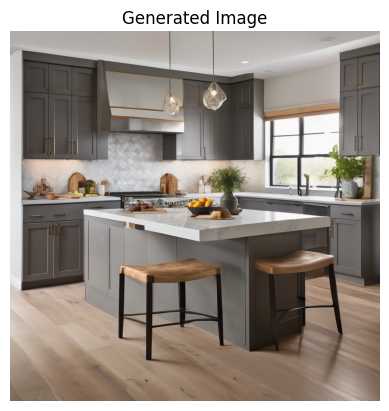

In [26]:
plt.imshow(generated_image[0])
plt.axis("off")
plt.title("Generated Image")
plt.show()
generated_image[0].save("generated_kitchen.png")  # You can change the filename/path